# Notebook 27: Computing and sampling the IGIMF as a function of redshift and metallicity

As a demonstration, here we calculate and then perform a random sampling of the IGIMF as a fucntion of redshift and metallicity while employing the analytical SFZR from Notebooks 24 and 26.

## Prelude

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.constants as ct
import astropy.units as u
import warnings
from pathlib import Path
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
def FeH_to_Z(FeH):
    return 10**FeH*0.02

# Initial Mass Function

## Stellar IMF

#### Local IMF

In [4]:
class Star():
    
    def __init__(self, FeH, Mecl):
        self.FeH = FeH
        self.Mecl = Mecl
        self.Mecl_min = 5
        self.Mmin = 0.08
        self.Mmax = None
        self._initial_guesses = None
        self._a1 = None
        self._a2 = None
        self._a3 = None
        self._afac = None
        self._x = None
        self.k1 = None
        self.k2 = None
        self.k3 = None   
        self._g1 = None
        self._g2 = None

    @property
    def x(self):
        if self._x is None:
            self._x = -0.14*self.FeH + 0.6*np.log10(self.Mecl/1e6) + 2.83
        return self._x
    
    @property
    def a1(self):
        if self._a1 is None:
            alpha1c = 1.3
            delta = 0.5
            self._a1 = alpha1c + delta * self.FeH
        return self._a1
    
    @property    
    def a2(self):
        if self._a2 is None:
            alpha2c = 2.3
            delta = 0.5
            self._a2 = alpha2c + delta * self.FeH
        return self._a2
    
    @property
    def a3(self):
        if self._a3 is None:
            if self.x < -0.87:
                self._a3 = 2.3
            elif self.x <= 1.94/0.41:
                self._a3 =-0.41*self.x + 1.94
            else:
                self._a3 = 0
        return self._a3
    
    @property
    def afac(self):
        if self._afac is None:
            self._afac = 2**(self.a1-self.a2)
        return self._afac    
    
    @property
    def g1(self):
        if self._g1 is None:
            self._g1 = self.h2(self.a1, self.Mmin, 0.5)
        return self._g1
    
    @property
    def g2(self):
        if self._g2 is None:
            self._g2 = self.h2(self.a2, 0.5, 1)
        return self._g2
            
    def h1(self, a, M1, M2):
        if a == 1:
            return np.log(M2/M1)
        else:
            return M2**(1-a)/(1-a) - M1**(1-a)/(1-a)
    
    def h2(self, a, M1, M2):
        if a == 2:
            return np.log(M2/M1)
        else:
            return M2**(2-a)/(2-a) - M1**(2-a)/(2-a)
        
    def f1(self, k1, Mmax):
        return 1 - self.afac*k1*self.h1(self.a3, Mmax, 150)
    
    def f2(self, k1, Mmax):
        g3 = self.h2(self.a3, 1, Mmax)
        return self.Mecl - k1 * (g3 + self.afac*(self.g1 + self.g2) )
    
    def constraints(self, vec):
        k1, Mmax = vec
        if k1<0 or Mmax<0:
            return (np.infty, np.infty)
        f1 = self.f1(k1, Mmax)
        f2 = self.f2(k1, Mmax)
        return (f1, f2)    
    
    def initial_guesses(self):
        norm = 10**(int(np.log10(self.Mecl))//2)
        k1 = 2**(1-self.a1)*self.Mecl/norm
        if self.a3 == 0:
            Mmax = 150
        else:
            Mmax = min(150, max(0.08, k1**(1/self.a3)))
        return (k1, Mmax)
            
    def get_Mmax_k1(self):
        if self.Mecl < self.Mecl_min:
            self.Mmax = 0
            self.k1 = 0
            self.set_k2_k3()
        else:
            self.k1, self.Mmax = fsolve(self.constraints, self.initial_guesses())
    
    def set_k2_k3(self):
        self.k2 = self.afac*self.k1
        self.k3 = self.k2
    
    def IMF(self, M):
        if self.Mmax is None:
            print('Please run get_Mmax_k first.')
            return
        if M < self.Mmin:
            return 0
        elif M < 0.5:
            return self.k1 * M**-self.a1
        elif M < 1:
            return self.k2 * M**-self.a2
        elif M <= self.Mmax:
            return self.k3 * M**-self.a3
        else:
            return 0

## Embedded cluster IMF

#### ECL IMF

In [5]:
class EmbeddedCluster():
    
    def __init__(self, SFR, time):
        self.SFR = SFR
        self.time = time
        self.Mtot = SFR*time
        self.k = None
        self.Mmin = 5
        self.Mmax = None
        self._beta = None
        self._g0 = None
        self._g1 = None
        self._g2 = None
        
    @property
    def beta(self):
        if self._beta is None:
            self._beta = -0.106*np.log10(self.SFR) + 2
        return self._beta
    
    def h0(self, M1, M2):
        return M1**(2-self.beta) + (2-self.beta)/(1-self.beta) * self.Mtot * M2**(1-self.beta)
    
    @property
    def g0(self):
        if self._g0 is None:
            self._g0 = self.h0(self.Mmin, 1e9)
        return self._g0
    
    def h1(self, M1, M2):
        return M1 + self.Mtot*np.log(M2)
    
    @property
    def g1(self):
        if self._g1 is None:
            self._g1 = self.h1(self.Mmin, 1e9)
        return self._g1
    
    def h2(self, M1, M2):
        return np.log(M1) - self.Mtot/M2
    
    @property
    def g2(self):
        if self._g2 is None:
            self._g2 = self.h2(self.Mmin, 1e9)
        return self._g2
        
    def f0(self, Mmax):
        return self.h0(Mmax, Mmax) - self.g0
    
    def f1(self, Mmax):
        return self.h1(Mmax, Mmax) - self.g1
    
    def f2(self, Mmax):
        return self.h2(Mmax, Mmax) - self.g2
    
    def initial_guess(self):
        return min(1e9, 1e6*self.SFR)
    
    def constraints(self, Mmax):
        if Mmax<0:
            return np.infty
        if self.beta == 2:
            return self.f2(Mmax)
        elif self.beta == 1:
            return self.f1(Mmax)
        else:
            return self.f0(Mmax)      
    
    def _get_Mmax(self):
        [self.Mmax] = fsolve(self.constraints, self.initial_guess())

    def _get_k(self):
        if self.beta == 2:
            self.k = 1/(1/self.Mmax - 1e-9)
        elif self.beta == 1:
            self.k = self.Mtot / (self.Mmax - self.Mmin)
        else:
            a = 1-self.beta
            self.k = a / (1e9**a - self.Mmax**a)
    
    def get_Mmax_k(self):
        self._get_Mmax()
        self._get_k()
        
    def IMF(self, Mecl):
        if Mecl <= self.Mmin:
            return 0
        elif Mecl < self.Mmax:
            return self.k*Mecl**-self.beta
        else:
            return 0   

## Integrated galaxy-wide IMF (IGIMF)

#### IGIMF

In [6]:
class Galaxy():
    
    def __init__(self, SFR, FeH):
        self.SFR = SFR
        self.FeH = FeH
        self.time = 1e7 #yr
        self.clusters = None
        self.Mecl_max = None
        self.Mecl_min = 5
        
    def get_clusters(self):
        self.clusters = EmbeddedCluster(self.SFR, self.time)
        self.clusters.get_Mmax_k()
        self.Mecl_max = self.clusters.Mmax
    
    def get_stars(self, Mecl, m):
        stellar = Star(self.FeH, Mecl)
        stellar.get_Mmax_k1()
        stellar.set_k2_k3()
        return stellar.IMF(m)

    def integrand(self, Mecl, m):
        if Mecl > self.Mecl_max:
            return 0
        IMF_stellar = self.get_stars(Mecl, m)
        IMF_cluster = self.clusters.IMF(Mecl)
        return IMF_stellar*IMF_cluster
    
    def IMF(self, m):
        IMF = quad(self.integrand, self.Mecl_min, self.Mecl_max, args=(m))
        return IMF

# Star-Formation Rate

In [7]:
SFR_GRID_PATH = Path('SFR_grid.txt')
SFR_grid = np.loadtxt(SFR_GRID_PATH)

In [8]:
IMF_grid_Ms = np.logspace(np.log10(0.08), np.log10(150), 100)

In [9]:
counter = 1
for gridpoint in SFR_grid:
    print(f'Now computing IMF for z = {gridpoint[0]}, [Fe/H] = {gridpoint[1]} and SFR = {gridpoint[2]} Msun yr-1 ({counter} of {len(SFR_grid)}).')
    filename = Path('N07_IMFgrid', f'IMF_z{gridpoint[0]*100:.0f}_FeH{gridpoint[1]*100:.0f}.txt')
    
    if filename.is_file():
        print(f'{filename} found. Skipping...')
    else:
        galaxy = Galaxy(10**gridpoint[2], gridpoint[1])
        galaxy.get_clusters()
        IMF = np.array([galaxy.IMF(M) for M in IMF_grid_Ms])
        np.savetxt(file, IMF)
    counter += 1

Now computing IMF for z = 0.01, [Fe/H] = -2.5 and SFR = -2.34575135806541 Msun yr-1 (1 of 16).
N07_IMFgrid/IMF_z1_FeH-250.txt found. Skipping...
Now computing IMF for z = 0.01, [Fe/H] = -1.5 and SFR = -1.4508367389280006 Msun yr-1 (2 of 16).
N07_IMFgrid/IMF_z1_FeH-150.txt found. Skipping...
Now computing IMF for z = 0.01, [Fe/H] = -0.5000000000000002 and SFR = -0.6283157770295098 Msun yr-1 (3 of 16).
N07_IMFgrid/IMF_z1_FeH-50.txt found. Skipping...
Now computing IMF for z = 0.01, [Fe/H] = 0.49999999999999956 and SFR = 0.6621798469000524 Msun yr-1 (4 of 16).
N07_IMFgrid/IMF_z1_FeH50.txt found. Skipping...
Now computing IMF for z = 0.6066666666666667, [Fe/H] = -2.5 and SFR = -1.945879551268022 Msun yr-1 (5 of 16).
N07_IMFgrid/IMF_z61_FeH-250.txt found. Skipping...
Now computing IMF for z = 0.6066666666666667, [Fe/H] = -1.5 and SFR = -0.9628935734347193 Msun yr-1 (6 of 16).
N07_IMFgrid/IMF_z61_FeH-150.txt found. Skipping...
Now computing IMF for z = 0.6066666666666667, [Fe/H] = -0.5000000

In [10]:
OUTPUT = list(Path('N07_IMFgrid').glob('IMF_*.txt'))

In [11]:
IMF_rough_grid = []

for output in OUTPUT:
    z, FeH = output.stem.split('_')[1:]
    z = int(z.lstrip('z'))*0.01
    FeH = int(FeH.lstrip('FeH'))*0.01
    IMF = np.loadtxt(output)
    IMF_corrected = []
    for i,x in enumerate(IMF[:,0]):
        y = IMF[i]
        if x < 0:
            y = [(IMF[i-1,0]+IMF[i+1,0])/2, (IMF[i-1,1]+IMF[i+1,1])/2]
        IMF_corrected.append(y)
    IMF_corrected = np.array(IMF_corrected)
    gridpoint = [z, FeH, IMF_corrected]
    IMF_rough_grid.append(gridpoint)

In [12]:
finegrid_masses = np.logspace(np.log10(0.08), np.log10(150), 100)

In [13]:
IMF_fine_grid = []
for gridpoint in IMF_rough_grid:
    IMF = gridpoint[-1][:,0]
    f = interp1d(IMF_grid_Ms, IMF)
    fineIMF = f(finegrid_masses)
    IMF_gridpoint = [gridpoint[0], FeH_to_Z(gridpoint[1]), fineIMF]
    IMF_fine_grid.append(IMF_gridpoint)
    
IMF_fine_grid = np.array(IMF_fine_grid)

In [14]:
unique_z_count = np.unique(IMF_fine_grid[:,0]).shape[0]
unique_Z_count = np.unique(IMF_fine_grid[:,1]).shape[0]
metallicities = np.unique(IMF_fine_grid[:,1])
redshifts = np.unique(IMF_fine_grid[:,0])

In [15]:
metallicities

array([6.324555320336759e-05, 0.0006324555320336759, 0.006324555320336759,
       0.0632455532033676], dtype=object)

Text(0.5, -0.01, '$M\\,[M_\\odot]$')

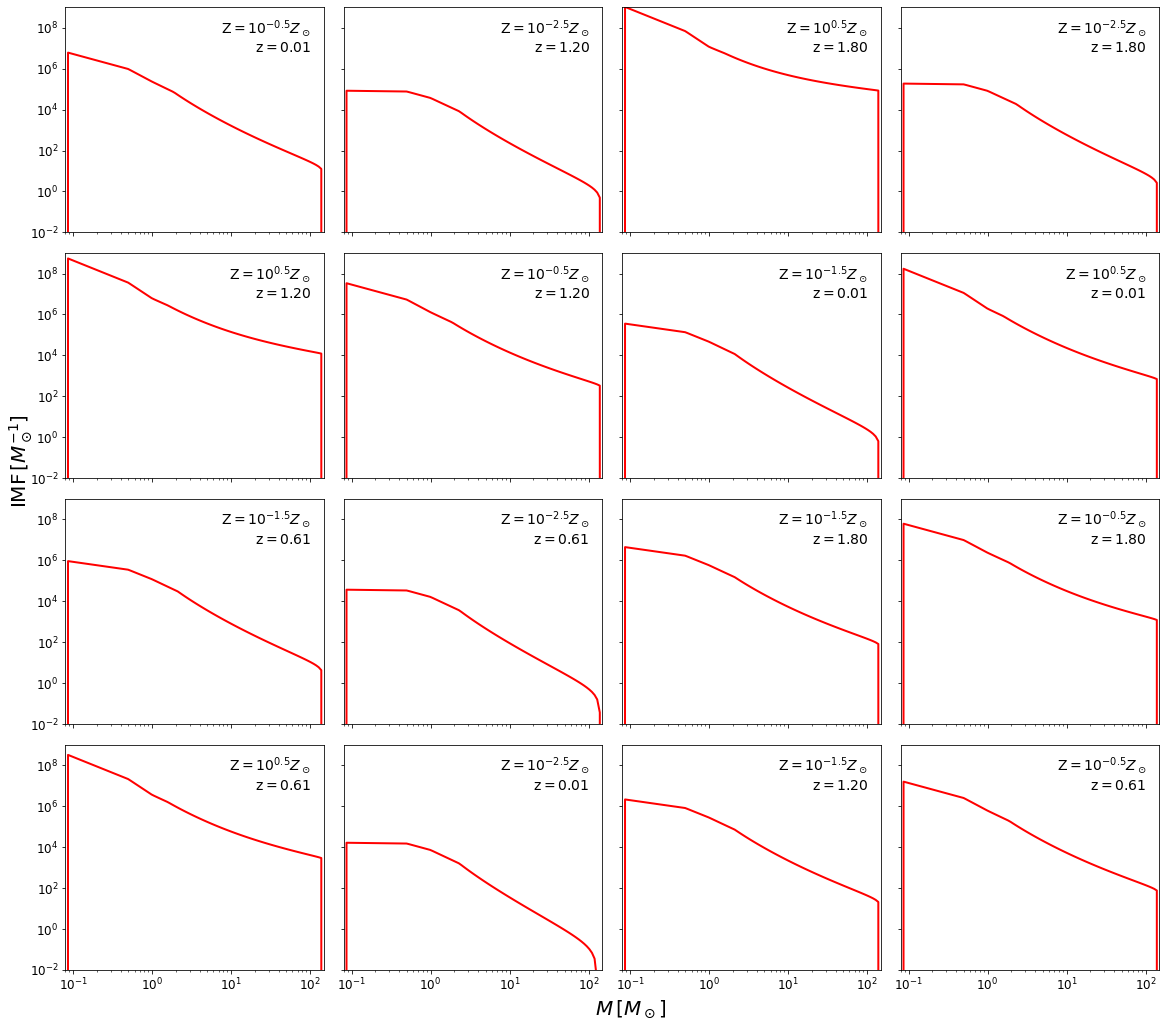

In [16]:
fig, axes = plt.subplots(unique_z_count, unique_Z_count, figsize=(16,14), sharex='col', sharey='row', tight_layout=True)
axess = axes.flatten()

for gridpoint, ax in zip(IMF_fine_grid, axess):
    z = np.float64(gridpoint[0])
    Z = np.float64(gridpoint[1])
    IMF = np.float64(gridpoint[2])
    ax.plot(finegrid_masses, IMF, 'r-', lw=2)

    textstr = '\n'.join((r'$\mathrm{Z}=10^{%.1f} Z_\odot$' % np.log10(Z/0.02),
                         r'$\mathrm{z}=%.2f$' % z))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', ha='right')
    
    ax.set_xlim(0.08, 150)
    ax.set_ylim(1e-2, 1e9)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
    
fig.text(-0.01, 0.5, r'$\mathrm{IMF}\,[M_\odot^{-1}]$', rotation=90, fontsize=20)
fig.text(0.5, -0.01, r'$M\,[M_\odot]$', fontsize=20)

Text(0.4, -0.01, '$M\\,[M_\\odot]$')

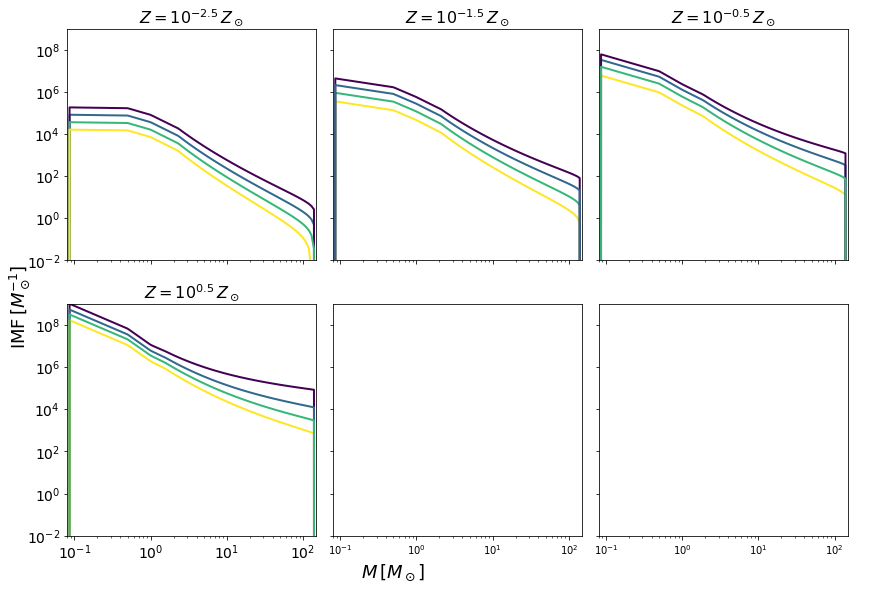

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(12,8), sharex='col', sharey='row', tight_layout=True)
axes = axs.flatten()
color_norm = max(redshifts) - min(redshifts)

for gridpoint in IMF_fine_grid:
    z = np.float64(gridpoint[0])
    Z = np.float64(gridpoint[1])
    IMF = np.float64(gridpoint[2])
    ax = axes[int(np.where(metallicities==Z)[0])]
    ax.plot(finegrid_masses, IMF, lw=2, c=cm.viridis_r((z-min(redshifts))/color_norm), label=f'z = {z:.2f}')

    #textstr = '\n'.join((r'$\mathrm{Z}=10^{%.1f} Z_\odot$' % np.log10(Z/0.02),
     #                    r'$\mathrm{z}=%.2f$' % z))
    #ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', ha='right')
    ax.set_title(r'$Z = 10^{%.1f}\,Z_\odot$'%np.log10(Z/0.02), fontsize=16)
    ax.set_xlim(0.08, 150)
    ax.set_ylim(1e-2, 1e9)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=14)
    
handles, labels = axes[-1].get_legend_handles_labels()  
axes[2].legend(handles[::-1], labels[::-1], loc=(1.05,0.08), frameon=False, fontsize=14)
    
fig.text(-0.01, 0.4, r'$\mathrm{IMF}\,[M_\odot^{-1}]$', rotation=90, fontsize=18)
fig.text(0.4, -0.01, r'$M\,[M_\odot]$', fontsize=18)

In [18]:
sampling_masses = np.logspace(np.log10(5), np.log10(150), int(1e5))

In [19]:
sampling_grid = []
for gridpoint in IMF_rough_grid:
    IMF = gridpoint[-1][:,0]
    f = interp1d(IMF_grid_Ms, IMF)
    samplingIMF = f(sampling_masses)
    sampling_gridpoint = [gridpoint[0], FeH_to_Z(gridpoint[1]), samplingIMF]
    sampling_grid.append(sampling_gridpoint)

sampling_grid = np.array(sampling_grid)

In [20]:
IMFsamples = []
for gridpoint in sampling_grid:
    probs = gridpoint[-1].astype(np.float64)
    probs /= probs.sum()
    sample = [gridpoint[0], gridpoint[1], np.random.choice(sampling_masses, p=probs, size=int(1e5))]
    IMFsamples.append(sample)

In [21]:
highmass_count = []
for sample in IMFsamples:
    masses = sample[-1]
    highmass = [mass for mass in masses if mass>=11]
    highmass_count.append([sample[0], sample[1], len(highmass)/len(masses)])

In [22]:
for item in highmass_count:
    print(item[0], item[1], f'{item[2]*100:.2f}%')

0.01 0.006324555320336759 21.93%
1.2 6.324555320336759e-05 18.12%
1.8 0.0632455532033676 48.71%
1.8 6.324555320336759e-05 19.88%
1.2 0.0632455532033676 39.67%
1.2 0.006324555320336759 27.25%
0.01 0.0006324555320336759 18.06%
0.01 0.0632455532033676 29.08%
0.61 0.0006324555320336759 20.13%
0.61 6.324555320336759e-05 16.88%
1.8 0.0006324555320336759 24.16%
1.8 0.006324555320336759 30.79%
0.61 0.0632455532033676 33.59%
0.01 6.324555320336759e-05 15.66%
1.2 0.0006324555320336759 22.17%
0.61 0.006324555320336759 24.35%


Text(0.5, -0.02, '$M_1(M_\\odot)$')

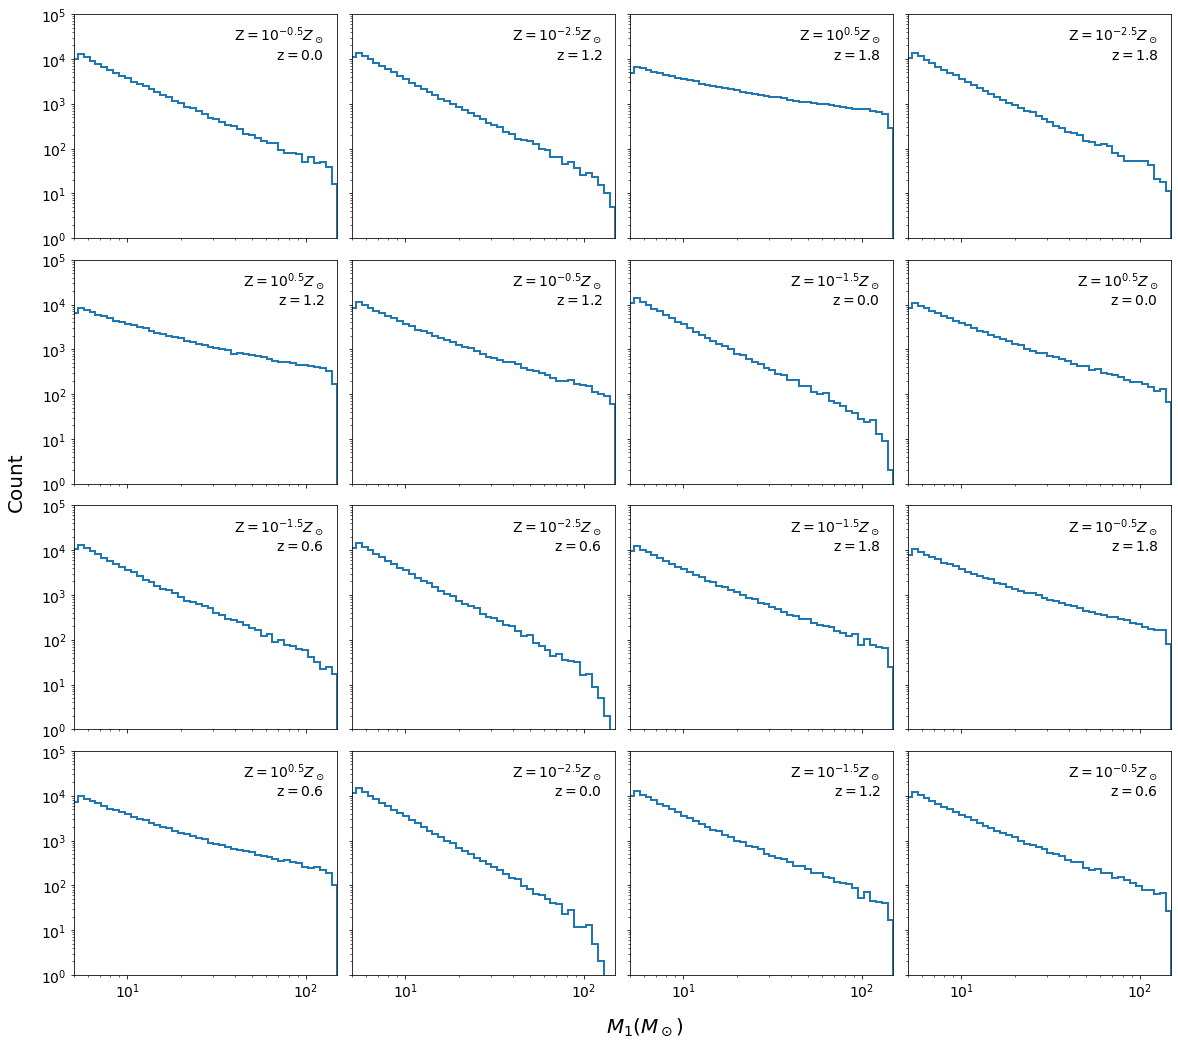

In [23]:
fig, axes = plt.subplots(unique_z_count, unique_Z_count, figsize=(16,14), sharex='col', sharey='row', tight_layout=True)
axess = axes.flatten()

i=0
for sample,ax in zip(IMFsamples, axess):
    z = np.float64(IMF_fine_grid[i][0])
    Z = np.float64(IMF_fine_grid[i][1])
    
    ax.hist(sample[-1], bins=finegrid_masses, histtype='step', lw=2)
#    ax.hist(sample[-1], bins=1, histtype='step')
    ax.set_xlim(5, 150)
    ax.set_ylim(1e0, 1e5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.tick_params(axis='both', labelsize=14)
    
    textstr = '\n'.join((r'$\mathrm{Z}=10^{%.1f} Z_\odot$' % np.log10(Z/0.02),
                         r'$\mathrm{z}=%.1f$' % z))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', ha='right')
    i += 1
    
fig.text(-0.02, 0.5, 'Count', rotation=90, fontsize=20)
fig.text(0.5, -0.02, r'$M_1(M_\odot)$', fontsize=20)

Text(0.4, -0.01, '$M_\\mathrm{1,ZAMS}\\,[M_\\odot]$')

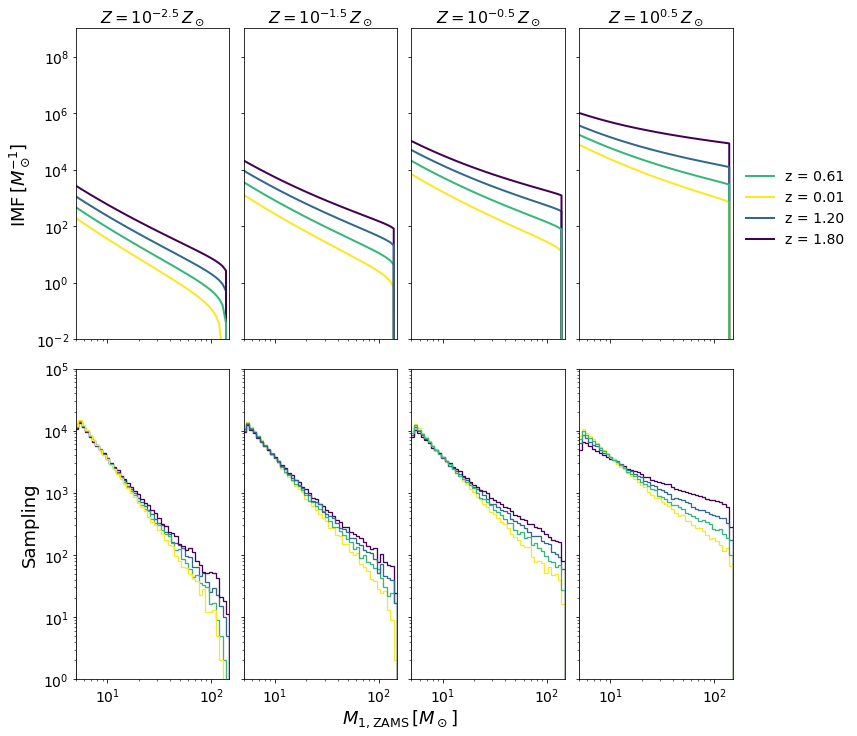

In [24]:
fig, axes = plt.subplots(2, unique_Z_count, figsize=(12,10), sharex='col', sharey='row', tight_layout=True)
color_norm = max(redshifts) - min(redshifts)

for gridpoint in IMF_fine_grid:
    z = np.float64(gridpoint[0])
    Z = np.float64(gridpoint[1])
    IMF = np.float64(gridpoint[2])
    ax = axes[0, int(np.where(metallicities==Z)[0])]
    ax.plot(finegrid_masses, IMF, lw=2, c=cm.viridis_r((z-min(redshifts))/color_norm), label=f'z = {z:.2f}')

    #textstr = '\n'.join((r'$\mathrm{Z}=10^{%.1f} Z_\odot$' % np.log10(Z/0.02),
     #                    r'$\mathrm{z}=%.2f$' % z))
    #ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', ha='right')
    ax.set_title(r'$Z = 10^{%.1f}\,Z_\odot$'%np.log10(Z/0.02), fontsize=16)
    ax.set_xlim(0.08, 150)
    ax.set_ylim(1e-2, 1e9)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=14)
    
handles, labels = axes[0,-1].get_legend_handles_labels()  
axes[0,-1].legend(handles[::-1], labels[::-1], loc=(1.05,0.28), frameon=False, fontsize=14)
axes[0,0].set_ylabel(r'$\mathrm{IMF}\,[M_\odot^{-1}]$', fontsize=18)

i=0
for sample in IMFsamples:
    z = np.float64(IMF_fine_grid[i][0])
    Z = np.float64(IMF_fine_grid[i][1])
    
    ax = axes[1, int(np.where(metallicities==Z)[0])]

    ax.hist(sample[-1], bins=finegrid_masses, histtype='step', lw=1.3, edgecolor=cm.viridis_r((z-min(redshifts))/color_norm), label=f'z = {z:.2f}')               

    #ax.set_title(r'$Z = 10^{%.1f}\,Z_\odot$'%np.log10(Z/0.02), fontsize=16)
    ax.set_xlim(5, 150)
    ax.set_ylim(1e0, 1e5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=14)
    i += 1
      
axes[1,0].set_ylabel('Sampling', fontsize=18)
fig.text(0.4, -0.01, r'$M_\mathrm{1,ZAMS}\,[M_\odot]$', fontsize=18)